## CASA0002_Urban simulation

# Underground Commuters Practical

Antonia Godoy-Lorite, Elsa Arcaute

March 2021

In [ ]:
pip install geopandas

Hello

In [ ]:
pip install cdlib

     |████████████████████████████████| 153kB 4.1MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 40.6MB 105kB/s 
     |████████████████████████████████| 1.8MB 30.2MB/s 
     |████████████████████████████████| 24.2MB 39.8MB/s 
  Created wheel for karateclub: filename=karateclub-1.0.24-cp37-none-any.whl size=94202 sha256=031a253404449773d102bf0f31cc7f57e7aec37f4b86fc7b0f33db2fa9b44a7e
  Stored in directory: /root/.cache/pip/wheels/ab/a4/81/a2761ff51bb1caa318e69e4a30f5d7d39c14f10efe73365279
  Created wheel for python-louvain: filename=python_louvain-0.14-cp37-none-any.whl size=9292 sha256=347bf43f70e2eb732b627112a27b9df09b13f524277851a2012dc4dd1bc2efd9
  Stored in directory: /root/.cache/pip/wheels/e7/8d/24/6b3a464bb23e96ecba3f68868e85721534fd8158a9cd7b426b
Successfully built karateclub python-louvain
  Found existing installation: python-louvain 0.15
    Uninstalling python-louvain-0.15:
      Successfully uninstalled python-louvain-0.1

This practical will show you how to create Commuting flows network, in this case for commuter in the London tube, and analyse these flows in terms of centrality and disruptions.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

First, we are going to read the underground network presented in previous practicals. This is going to be the underlying network used by commuters:

In [ ]:
# Let's create a graph from the shapefile
g_shp=nx.read_shp('underground.shp',geom_attrs=False)

# We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(g_shp)
df[0:10]

,source,target,station_1,station_2,station_1_,distance,station_2_,ShpName,toid_seq
0,"(-0.1571, 51.5226)","(-0.1631, 51.5225)",11,163,Baker Street,416.586050,Marylebone,underground,1
1,"(-0.1571, 51.5226)","(-0.1466, 51.5234)",11,212,Baker Street,734.173636,Regent's Park,underground,2
2,"(-0.1571, 51.5226)","(-0.17, 51.5203)",11,83,Baker Street,931.211577,Edgware Road (C),underground,171
3,"(-0.1571, 51.5226)","(-0.1439, 51.5238)",11,104,Baker Street,925.826411,Great Portland Street,underground,225
4,"(-0.1571, 51.5226)","(-0.1494, 51.5142)",11,28,Baker Street,1076.607648,Bond Street,underground,197
5,"(-0.1571, 51.5226)","(-0.174, 51.5347)",11,249,Baker Street,1785.442777,St. John's Wood,underground,198
6,"(-0.1571, 51.5226)","(-0.1803, 51.5472)",11,94,Baker Street,3175.274183,Finchley Road,underground,226
7,"(-0.1247, 51.508)","(-0.1223, 51.5074)",49,87,Charing Cross,179.503418,Embankment,underground,277
8,"(-0.1247, 51.508)","(-0.1342, 51.5098)",49,197,Charing Cross,689.289845,Picadilly Circus,underground,4
9,"(-0.1247, 51.508)","(-0.1281, 51.5113)",49,151,Charing Cross,436.484594,Leicester Square,underground,278


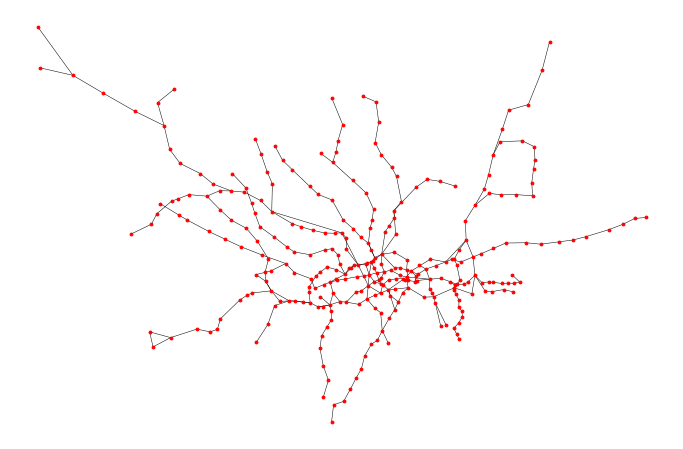

In [ ]:
# Let's plot the tube network:

# first we need to extract the coordinates from every node:
pos = {xy: xy for xy in g_shp.nodes()}

fig, ax = plt.subplots(figsize=(12,8))

nx.draw_networkx_nodes(g_shp,pos,node_size=8,node_color='r')
nx.draw_networkx_edges(g_shp,pos,arrows=False,width=0.5)
plt.axis("off")
plt.show()

In [ ]:
#Now, let's check attributes of edges and nodes:
#edges:
list(g_shp.edges(data = True))[0]

((-0.1571, 51.5226),
 (-0.1631, 51.5225),
 {'ShpName': 'underground',
  'distance': 416.586050414,
  'station_1': 11,
  'station_1_': 'Baker Street',
  'station_2': 163,
  'station_2_': 'Marylebone',
  'toid_seq': '1'})

In [ ]:
#nodes:
list(g_shp.nodes(data=True))[0:10]

[((-0.1571, 51.5226), {}),
 ((-0.1631, 51.5225), {}),
 ((-0.1466, 51.5234), {}),
 ((-0.1247, 51.508), {}),
 ((-0.1223, 51.5074), {}),
 ((-0.1342, 51.5098), {}),
 ((-0.1679, 51.5199), {}),
 ((-0.1755, 51.5154), {}),
 ((-0.1001, 51.4943), {}),
 ((-0.1115, 51.4991), {})]

In [ ]:
#we will need to add station names as attributes of the nodes:
nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}
#nod_all = {**nod_st1, **nod_st2} #for python 3.5 and greater

#In Python 2, (or 3.4 or lower) write a function
nod_all = nod_st1.copy()   # start with x's keys and values
nod_all.update(nod_st2)

nx.set_node_attributes(g_shp,nod_all,'station')

# get the nodes attributes:
list(g_shp.nodes(data=True))[0:10]

[((-0.1571, 51.5226), {'station': 'Baker Street'}),
 ((-0.1631, 51.5225), {'station': 'Marylebone'}),
 ((-0.1466, 51.5234), {'station': "Regent's Park"}),
 ((-0.1247, 51.508), {'station': 'Charing Cross'}),
 ((-0.1223, 51.5074), {'station': 'Embankment'}),
 ((-0.1342, 51.5098), {'station': 'Picadilly Circus'}),
 ((-0.1679, 51.5199), {'station': 'Edgware Road (B)'}),
 ((-0.1755, 51.5154), {'station': 'Paddington'}),
 ((-0.1001, 51.4943), {'station': 'Elephant & Castle'}),
 ((-0.1115, 51.4991), {'station': 'Lambeth North'})]

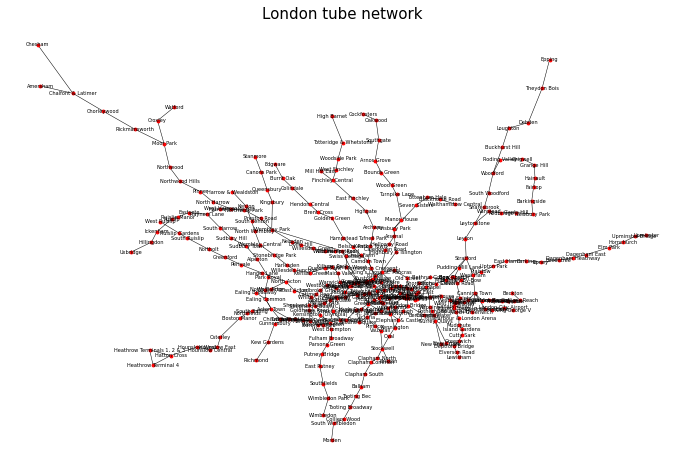

In [ ]:
#We can plot the underground network with stations names:
fig, ax = plt.subplots(figsize=(12,8))

node_labels = nx.get_node_attributes(g_shp, 'station')

pos = {xy: xy for xy in g_shp.nodes()}

nx.draw_networkx_nodes(g_shp,pos,node_size=8,node_color='r')
nx.draw_networkx_edges(g_shp,pos,arrows=False,width=0.5)
nx.draw_networkx_labels(g_shp,pos, node_labels, font_size=5,font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

In [ ]:
#do we want this graph to be a directed one? In fact, only a few links in the dataset are directed

# We can transform the type of graph from directed to undirected using the following function:
g_shp_un = g_shp.to_undirected()

#Finally, we will give an ID to each node(station), such that it will be easier later to call them:
#1.Create a new attribute with node coordinates (now coord are the keys and we do not want to lose that information
nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,nod_coord,'station_coord')
list(g_shp_un.nodes(data=True))[0:10]


[((-0.1571, 51.5226),
  {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)}),
 ((-0.1631, 51.5225),
  {'station': 'Marylebone', 'station_coord': (-0.1631, 51.5225)}),
 ((-0.1466, 51.5234),
  {'station': "Regent's Park", 'station_coord': (-0.1466, 51.5234)}),
 ((-0.1247, 51.508),
  {'station': 'Charing Cross', 'station_coord': (-0.1247, 51.508)}),
 ((-0.1223, 51.5074),
  {'station': 'Embankment', 'station_coord': (-0.1223, 51.5074)}),
 ((-0.1342, 51.5098),
  {'station': 'Picadilly Circus', 'station_coord': (-0.1342, 51.5098)}),
 ((-0.1679, 51.5199),
  {'station': 'Edgware Road (B)', 'station_coord': (-0.1679, 51.5199)}),
 ((-0.1755, 51.5154),
  {'station': 'Paddington', 'station_coord': (-0.1755, 51.5154)}),
 ((-0.1001, 51.4943),
  {'station': 'Elephant & Castle', 'station_coord': (-0.1001, 51.4943)}),
 ((-0.1115, 51.4991),
  {'station': 'Lambeth North', 'station_coord': (-0.1115, 51.4991)})]

In [ ]:
#2.now relabel each node with an ordered integer:
node_list = list(g_shp_un.nodes())
mapping = {node_list[i]:i for i in range(len(node_list))}
g_shp_un = nx.relabel_nodes(g_shp_un, mapping)
list(g_shp_un.nodes(data=True))[0:10]

[(0, {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)}),
 (1, {'station': 'Marylebone', 'station_coord': (-0.1631, 51.5225)}),
 (2, {'station': "Regent's Park", 'station_coord': (-0.1466, 51.5234)}),
 (3, {'station': 'Charing Cross', 'station_coord': (-0.1247, 51.508)}),
 (4, {'station': 'Embankment', 'station_coord': (-0.1223, 51.5074)}),
 (5, {'station': 'Picadilly Circus', 'station_coord': (-0.1342, 51.5098)}),
 (6, {'station': 'Edgware Road (B)', 'station_coord': (-0.1679, 51.5199)}),
 (7, {'station': 'Paddington', 'station_coord': (-0.1755, 51.5154)}),
 (8, {'station': 'Elephant & Castle', 'station_coord': (-0.1001, 51.4943)}),
 (9, {'station': 'Lambeth North', 'station_coord': (-0.1115, 51.4991)})]

In [ ]:
#Later when using the Commuters data we will have an issue mapping node 'Heathrow Terminals 1, 2 & 3', 
#so we are going to rename it here:
#1. find the node 'Heathrow Terminals 1, 2 & 3'
nodes = [(x,y) for x,y in g_shp_un.nodes(data='station') if 'Heathrow' in str(y)]
nodes

[(258, 'Heathrow Terminals 1, 2 & 3'), (259, 'Heathrow Terminal 4')]

In [ ]:
#2.Rename it with the name given by the the commuters file (see later):
g_shp_un.nodes[258]['station']='Heathrow Terminals 123'

## Commuters flows in the tube network

We are going to create the flows of commuters travelling between any pair of tube stations

In [ ]:
import pandas as pd
#First, we read the csv file with commuting flows starting and ending between stations, called Origin-Destination:
#Check you are in the correct directory to read the csv 


In [ ]:
# Read Origin-Destination table from the csv
orig_dest = pd.read_csv('ODtube2017.csv')
orig_dest.head()

,From,station_name,To,station_name.1,total_wtrips
0,500,Acton Town,505,Alperton,143
1,500,Acton Town,506,Amersham,22
2,500,Acton Town,507,Angel,15
3,500,Acton Town,508,Archway,9
4,500,Acton Town,510,Arsenal,9


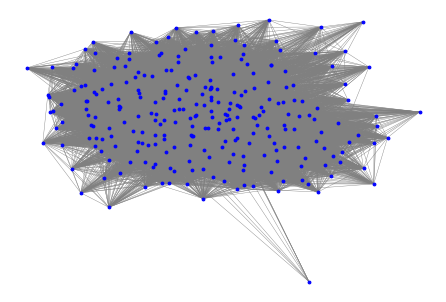

In [ ]:
#This can be seen as a network by itself:
g_OD = nx.from_pandas_edgelist(orig_dest, 'station_name', 'station_name.1',['total_wtrips'])

# Plot graph
nx.draw(g_OD,
        node_color='b',
        node_size=8,
        edge_color='gray',
        width=0.4)

In [ ]:
#Directed weighted network, weights are the total number of commuters from one station to another
list(g_OD.edges(data=True))[0:10]

[('Acton Town', 'Alperton', {'total_wtrips': 192}),
 ('Acton Town', 'Amersham', {'total_wtrips': 22}),
 ('Acton Town', 'Angel', {'total_wtrips': 15}),
 ('Acton Town', 'Archway', {'total_wtrips': 11}),
 ('Acton Town', 'Arsenal', {'total_wtrips': 16}),
 ('Acton Town', 'Baker Street', {'total_wtrips': 34}),
 ('Acton Town', 'Bank', {'total_wtrips': 157}),
 ('Acton Town', 'Barbican', {'total_wtrips': 7}),
 ('Acton Town', 'Barons Court', {'total_wtrips': 52}),
 ('Acton Town', 'Bayswater', {'total_wtrips': 6})]

In [ ]:
#Change the names of nodes by the id in g_shp_un (tube network):

#1.Copy name as an attribute:
nod_names={(e1):e1 for e1 in g_OD.nodes()}
nx.set_node_attributes(g_OD,nod_names,'station') #with nod_id1 or nod_id2 is enought
print(list(g_OD.nodes(data=True))[:10])

[('Acton Town', {'station': 'Acton Town'}), ('Alperton', {'station': 'Alperton'}), ('Amersham', {'station': 'Amersham'}), ('Angel', {'station': 'Angel'}), ('Archway', {'station': 'Archway'}), ('Arsenal', {'station': 'Arsenal'}), ('Baker Street', {'station': 'Baker Street'}), ('Bank', {'station': 'Bank'}), ('Barbican', {'station': 'Barbican'}), ('Barons Court', {'station': 'Barons Court'})]


In [ ]:
#2.Do the mapping with id in g_shp_un
mapping = {g_shp_un.nodes[i]['station']:i for i in g_shp_un.nodes()}
g_OD = nx.relabel_nodes(g_OD, mapping)
print(list(g_OD.nodes(data=True))[:10])

[(111, {'station': 'Acton Town'}), (238, {'station': 'Alperton'}), (172, {'station': 'Amersham'}), (196, {'station': 'Angel'}), (198, {'station': 'Archway'}), (244, {'station': 'Arsenal'}), (0, {'station': 'Baker Street'}), (25, {'station': 'Bank'}), (77, {'station': 'Barbican'}), (100, {'station': 'Barons Court'})]


In [ ]:
#and we can add coodenates to the nodes, from the shapefile of the tube network:
nod_coords={(e1):coord for e1, coord in g_shp_un.nodes(data='station_coord')}

nx.set_node_attributes(g_OD,nod_coords,'station_coord') #with nod_id1 or nod_id2 is enought

pos = {e1: xy for e1,xy in g_OD.nodes(data='station_coord')}


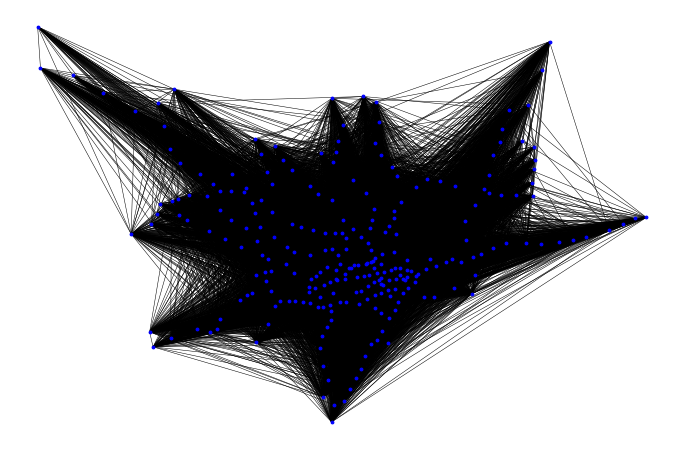

In [ ]:
#To finaly plot the OD matrix as a network:
fig, ax = plt.subplots(figsize=(12,8))

nx.draw_networkx_nodes(g_OD,g_OD.nodes(data='station_coord'),node_size=8,node_color='b')
nx.draw_networkx_edges(g_OD,pos,arrows=False,width=0.5)
plt.axis("off")
plt.show()



In [ ]:
#Even if we have not considered the weights (we will later on), 
#this network does not represent the commuting flows, what is happening?

#From the Origin Destination network, we need to compute the number of commuters for each pair of stations:
#How will we know the path of commuters from their origin to their destinations? 
#Given that the tube network is undirected and that we do not have information on the different tube lines, 
#we will assume that commuters use the shortest path between Origin and Destination

In [ ]:
#Now, let's create the network with the actual flow of commuters travelling between each pair of stations,
#regardless which was their origin and destination:

#We will create that graph using the adjacency matrix method that was presented in previous practicals:
#First we create an empty adjacency matrix:
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in g_OD.edges(data='total_wtrips'):
    path = nx.dijkstra_path(g_shp_un,e1,e2)  #shortest path e1,e2 taking into account distance weights in g_shp_un
    path_edges = list(zip(path,path[1:])) #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C #sum the contribution of the OD flow to all edges in the shortest path
adj_c

array([[    0., 15077.,  5715., ...,     0.,     0.,     0.],
       [ 1577.,     0.,     0., ...,     0.,     0.,     0.],
       [24645.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [ ]:
#Create the new graph from the adjancency matrix:
g_flows=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)


In [ ]:
#we need to give coordinates to these nodes too:
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_flows,nod_coord,'station_coord')
list(g_flows.nodes(data=True))[0:10]

[(0, {'station_coord': (-0.1571, 51.5226)}),
 (1, {'station_coord': (-0.1631, 51.5225)}),
 (2, {'station_coord': (-0.1466, 51.5234)}),
 (3, {'station_coord': (-0.1247, 51.508)}),
 (4, {'station_coord': (-0.1223, 51.5074)}),
 (5, {'station_coord': (-0.1342, 51.5098)}),
 (6, {'station_coord': (-0.1679, 51.5199)}),
 (7, {'station_coord': (-0.1755, 51.5154)}),
 (8, {'station_coord': (-0.1001, 51.4943)}),
 (9, {'station_coord': (-0.1115, 51.4991)})]

In [ ]:
#also the station names:
nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(g_flows,nod_names,'station')
list(g_flows.nodes(data=True))[0:10]

[(0, {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)}),
 (1, {'station': 'Marylebone', 'station_coord': (-0.1631, 51.5225)}),
 (2, {'station': "Regent's Park", 'station_coord': (-0.1466, 51.5234)}),
 (3, {'station': 'Charing Cross', 'station_coord': (-0.1247, 51.508)}),
 (4, {'station': 'Embankment', 'station_coord': (-0.1223, 51.5074)}),
 (5, {'station': 'Picadilly Circus', 'station_coord': (-0.1342, 51.5098)}),
 (6, {'station': 'Edgware Road (B)', 'station_coord': (-0.1679, 51.5199)}),
 (7, {'station': 'Paddington', 'station_coord': (-0.1755, 51.5154)}),
 (8, {'station': 'Elephant & Castle', 'station_coord': (-0.1001, 51.4943)}),
 (9, {'station': 'Lambeth North', 'station_coord': (-0.1115, 51.4991)})]

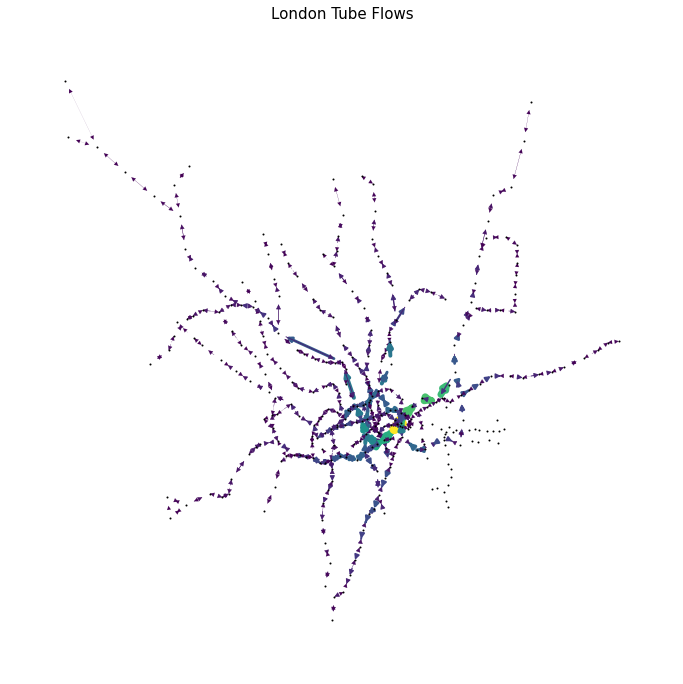

In [ ]:
# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in g_flows.edges(data='weight')]

weights_color=[(w/max(weights)) for e1,e2,w in g_flows.edges(data='weight')]
weights_size=[(w/max(weights)*10) for e1,e2,w in g_flows.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color=weights_color, width=weights_size)

nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.axis("off")
plt.title("London Tube Flows",fontsize=15)
plt.show()

#this are the directed flows in the tube network!

In [ ]:
#We can search for nodes in the flow network
#node
node = [(x,y) for x,y in g_flows.nodes(data='station') if y=='Kilburn']
node

[(168, 'Kilburn')]

In [ ]:
#or if you do not know how exacly it is written:
node2 = [(x,y) for x,y in g_flows.nodes(data='station') if 'Kil' in str(y)]
print(node2)
g_flows.nodes[19],g_flows.nodes[168] #the IDs may change for Python3/Python2 depending on the order of appearance

[(19, 'Kilburn Park'), (168, 'Kilburn')]


({'station': 'Kilburn Park', 'station_coord': (-0.1939, 51.5351)},
 {'station': 'Kilburn', 'station_coord': (-0.2047, 51.5471)})

In [ ]:
#We can also search edges, however, edges are called by the IDs, no by the names:
print(list(g_flows.edges(data=True))[0:10])


[(0, 1, {'weight': 15077.0}), (0, 2, {'weight': 5715.0}), (0, 33, {'weight': 42751.0}), (0, 75, {'weight': 71953.0}), (0, 76, {'weight': 22224.0}), (0, 152, {'weight': 11237.0}), (0, 165, {'weight': 88127.0}), (1, 0, {'weight': 1577.0}), (1, 6, {'weight': 4650.0}), (2, 0, {'weight': 24645.0})]


In [ ]:
#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(g_flows.nodes[e1]['station'],g_flows.nodes[e2]['station']) for e1,e2 in g_flows.edges()}

nx.set_edge_attributes(g_flows,edges_names,'station_names') 
print(list(g_flows.edges(data=True))[0:10])

[(0, 1, {'weight': 15077.0, 'station_names': ('Baker Street', 'Marylebone')}), (0, 2, {'weight': 5715.0, 'station_names': ('Baker Street', "Regent's Park")}), (0, 33, {'weight': 42751.0, 'station_names': ('Baker Street', 'Bond Street')}), (0, 75, {'weight': 71953.0, 'station_names': ('Baker Street', 'Edgware Road (C)')}), (0, 76, {'weight': 22224.0, 'station_names': ('Baker Street', 'Great Portland Street')}), (0, 152, {'weight': 11237.0, 'station_names': ('Baker Street', "St. John's Wood")}), (0, 165, {'weight': 88127.0, 'station_names': ('Baker Street', 'Finchley Road')}), (1, 0, {'weight': 1577.0, 'station_names': ('Marylebone', 'Baker Street')}), (1, 6, {'weight': 4650.0, 'station_names': ('Marylebone', 'Edgware Road (B)')}), (2, 0, {'weight': 24645.0, 'station_names': ("Regent's Park", 'Baker Street')})]


In [ ]:
#now, we can search edges by names, as for example all edges comming to and leaving from Kilburn Park:
edge = [(e1,e2) for e1,e2,y in g_flows.edges(data='station_names') if 'Kilburn Park' in str(y)]
print(edge)


[(17, 19), (19, 17), (19, 20), (20, 19)]


In [ ]:
g_flows.edges[(17, 19)] #Again, the IDs may change for Python3/Python2 depending on the order of appearance

{'station_names': ("Queen's Park", 'Kilburn Park'), 'weight': 1686.0}

## Centrality measures

Let's explore the commuting flows network with some exercises on different type of centrality measures and disruptions on the network. Keep in mind that this network is a directed network and nodes and edges centrality depends on the direction of the flows.

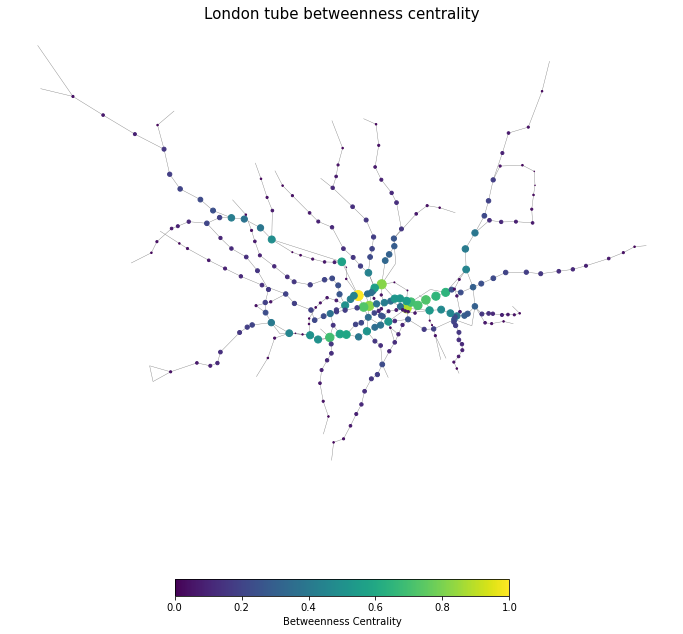

In [ ]:
#Let's compare node centrality for the undirected tube network and the directed commuting flows network:
#Let us compute the betweenness centrality for the undirected tube network, considering the distance between stations:
bet_london_w=nx.betweenness_centrality(g_shp_un, weight='distance', normalized=False)
# We can add these values as node attributes:
nx.set_node_attributes(g_shp_un,bet_london_w,'betweenness_un')

# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_un']) for i in g_shp_un.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_un']/max(betweenness_w_values)) for i in g_shp_un.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_un']/max(betweenness_w_values)*100) for i in g_shp_un.nodes(data=True)]


# Plot graph
#pos_shp = {xy: xy for xy in g_shp.nodes()}
pos={e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(g_shp_un, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.show()

In [ ]:
#get a list of nodes with higeher betweeness centrality:
dict_bet_un=dict(g_shp_un.nodes(data=True))

#Python2:
#import operator
#listbet_un=sorted(dict_bet_un.items(), key=operator.itemgetter(1),reverse=True)
#listbet_un[:10]

#Pyhton3:
from collections import OrderedDict
listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
list(listbet_un.items())[:10]

[(0,
  {'betweenness_un': 13194.0,
   'station': 'Baker Street',
   'station_coord': (-0.1571, 51.5226)}),
 (25,
  {'betweenness_un': 11605.0,
   'station': 'Bank',
   'station_coord': (-0.0886, 51.5133)}),
 (24,
  {'betweenness_un': 10847.0,
   'station': 'Oxford Circus',
   'station_coord': (-0.1415, 51.515)}),
 (88,
  {'betweenness_un': 10794.0,
   'station': "King's Cross St. Pancras",
   'station_coord': (-0.1238, 51.5308)}),
 (33,
  {'betweenness_un': 9597.0,
   'station': 'Bond Street',
   'station_coord': (-0.1494, 51.5142)}),
 (96,
  {'betweenness_un': 9500.0,
   'station': 'Whitechapel',
   'station_coord': (-0.0612, 51.5194)}),
 (95,
  {'betweenness_un': 9334.0,
   'station': 'Aldgate East',
   'station_coord': (-0.0726, 51.5154)}),
 (116,
  {'betweenness_un': 9201.0,
   'station': "Earl's Court",
   'station_coord': (-0.1973, 51.492)}),
 (26,
  {'betweenness_un': 9195.0,
   'station': 'Liverpool Street',
   'station_coord': (-0.0823, 51.5178)}),
 (131,
  {'betweenness_un': 

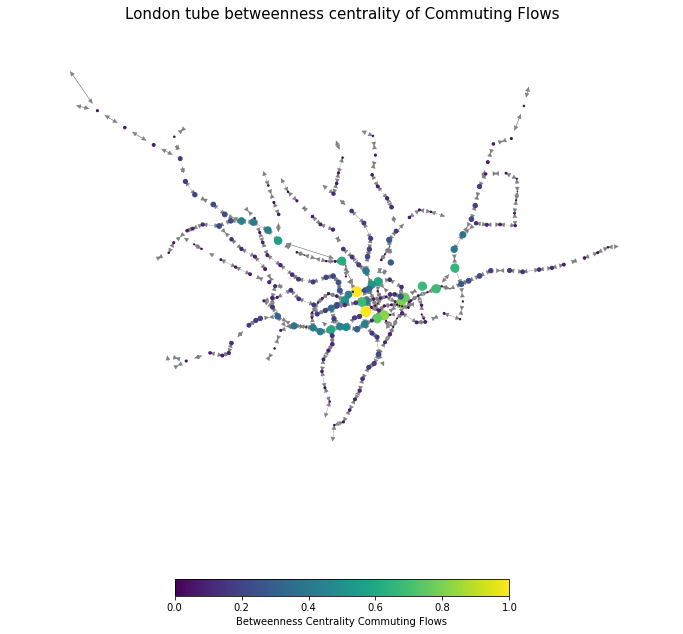

In [ ]:
#now let us compute betweenness centrality for directed commuting flows:
bet_london_w=nx.betweenness_centrality(g_flows, weight='weights', normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_flows,bet_london_w,'betweenness_flows')

betweenness_w_values=[(i[1]['betweenness_flows']) for i in g_flows.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_flows']/max(betweenness_w_values)) for i in g_flows.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_flows']/max(betweenness_w_values)*100) for i in g_flows.nodes(data=True)]

# Plot graph
pos={e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color='gray', width=0.4)

nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.axis("off")
plt.colorbar(nod,label="Betweenness Centrality Commuting Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality of Commuting Flows",fontsize=15)
plt.show()

In [ ]:
#list of top betweenness nodes for commuting flows:
dict_bet_flows=dict(g_flows.nodes(data=True))

#Python2
#import operator
#listbet_flows=sorted(dict_bet_flows.items(), key=operator.itemgetter(1),reverse=True)
#listbet_flows[:10]

#Pyhton3:
from collections import OrderedDict
listbet_flows=OrderedDict(sorted(dict_bet_flows.items(), key=lambda x: x[1]['betweenness_flows'],reverse=True))
list(listbet_flows.items())[:10]

[(0,
  {'betweenness_flows': 24154.52063492064,
   'station': 'Baker Street',
   'station_coord': (-0.1571, 51.5226)}),
 (155,
  {'betweenness_flows': 24011.180952380957,
   'station': 'Green Park',
   'station_coord': (-0.1428, 51.5067)}),
 (10,
  {'betweenness_flows': 19898.402380952422,
   'station': 'Waterloo',
   'station_coord': (-0.1143, 51.5036)}),
 (25,
  {'betweenness_flows': 19406.140476190427,
   'station': 'Bank',
   'station_coord': (-0.0886, 51.5133)}),
 (26,
  {'betweenness_flows': 18533.342857142845,
   'station': 'Liverpool Street',
   'station_coord': (-0.0823, 51.5178)}),
 (86,
  {'betweenness_flows': 18266.335714285695,
   'station': 'Westminster',
   'station_coord': (-0.1254, 51.501)}),
 (33,
  {'betweenness_flows': 16645.1015873016,
   'station': 'Bond Street',
   'station_coord': (-0.1494, 51.5142)}),
 (32,
  {'betweenness_flows': 16458.804761904787,
   'station': 'Mile End',
   'station_coord': (-0.0332, 51.5249)}),
 (31,
  {'betweenness_flows': 16337.12142857

We can do this comparison also for edges centrality, closeness and other metrics. Applied to nodes betweenness centrality, we observe changes in the top 10 considering station distances and considering the commuting flows. This fact points out the importance of considering the actual commuters flows to capture the importance of stations in the transportation network.

Identify whether the order of top stations is different or the same considering the commuting flows. Now think about how to measure the impact of the removal on the network.

### Remove 10 nodes

In [95]:
lst = [155, 10, 25, 26, 86, 33, 32, 31, 66]

In [97]:
for i in lst:
  g_flows.remove_nodes_from(i)
  l2=list(g_flows.nodes)
  print(len(l2))

296


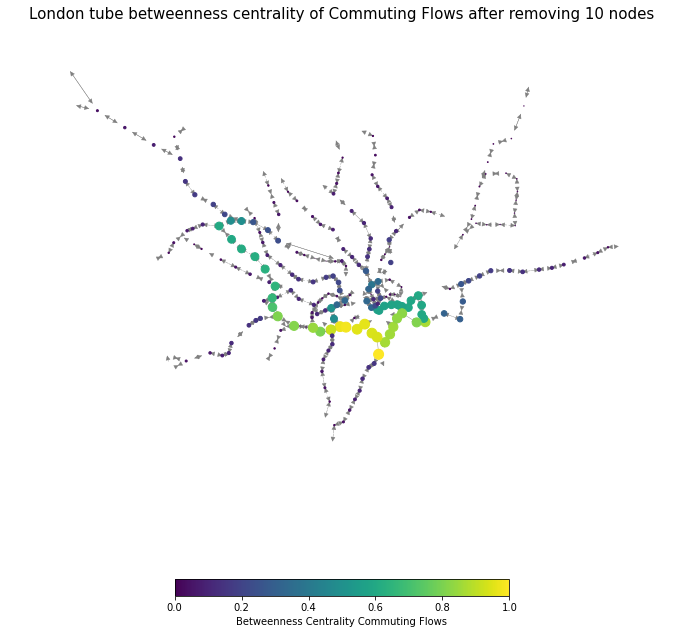

In [100]:
#now let us compute betweenness centrality for directed commuting flows:
bet_london_w=nx.betweenness_centrality(g_flows, weight='weights', normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_flows,bet_london_w,'betweenness_flows')

betweenness_w_values=[(i[1]['betweenness_flows']) for i in g_flows.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_flows']/max(betweenness_w_values)) for i in g_flows.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_flows']/max(betweenness_w_values)*100) for i in g_flows.nodes(data=True)]

# Plot graph
pos={e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color='gray', width=0.4)

nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.axis("off")
plt.colorbar(nod,label="Betweenness Centrality Commuting Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality of Commuting Flows after removing 10 nodes",fontsize=15)
plt.show()

### Impact Measures

In [102]:
print(nx.info(g_flows))
print(f'Highest degree node: {sorted(g_flows.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: DiGraph
Number of nodes: 296
Number of edges: 539
Average in degree:   1.8209
Average out degree:   1.8209
Highest degree node: (88, 14)


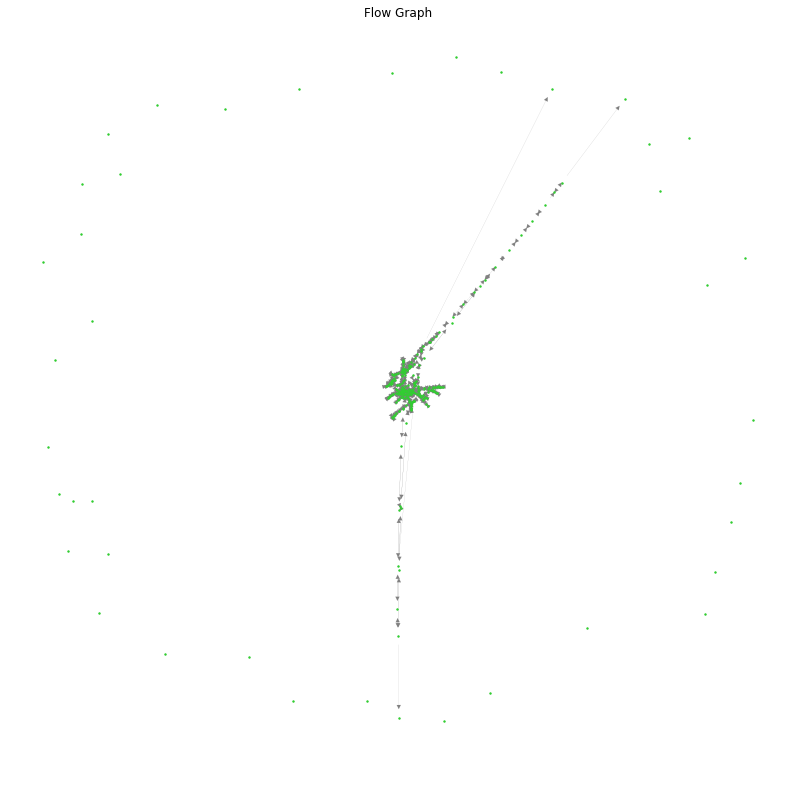

In [105]:
pos = nx.spring_layout(g_flows)
fig, ax = plt.subplots(figsize=(14,14))
nx.draw_networkx_edges(g_flows,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(g_flows, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('Flow Graph', fontsize=12)
plt.show()

In [111]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.strongly_connected_components(g_flows), key=len, reverse=True)

Gsub = g_flows.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(g_flows.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_strongly_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:53.72%
Name: 
Type: DiGraph
Number of nodes: 159
Number of edges: 330
Average in degree:   2.0755
Average out degree:   2.0755
Number of connected components:1
Highest degree nodes: 
 	7: 10
 	112: 10
 	116: 10
 	60: 8
 	101: 8


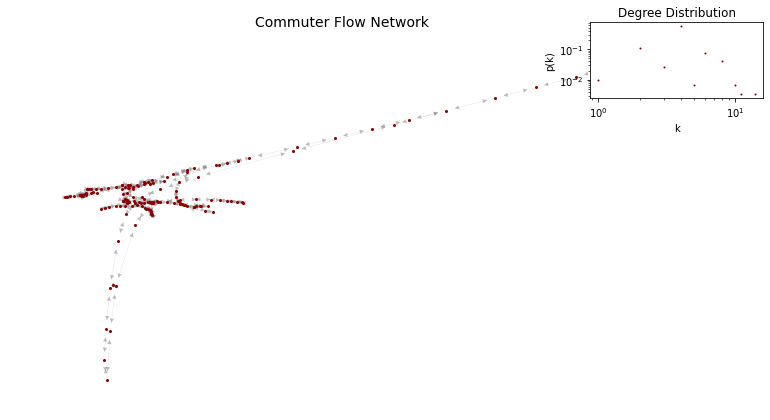

In [114]:
fig, ax = plt.subplots(figsize=(12,7))

# plot largest connected components
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Commuter Flow Network', fontsize=14)

# plot the degree distribution
# degree distribution will be covered next lecture 

degree_hist = nx.degree_histogram(g_flows) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/g_flows.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

In [113]:
# let's measure the clustering coefficient
c = nx.clustering(Gsub)
print(type(c))

# we can sort the dictionary by the clustering coefficient
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print(c[:5])

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

<class 'dict'>
[(102, 1.0), (110, 1.0), (258, 1.0), (259, 1.0), (89, 0.3333333333333333)]
avg clustering coefficient: 0.03542976939203354


fast greedy

In [115]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# let's start with greedy modularity
communities_fg = greedy_modularity_communities(Gsub)

print(f'number of communities: {len(communities_fg)}')

KeyError: ignored

In [116]:
# we can sort this communities to plot only the largest communities 
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

# plot the entire graph with gray nodes
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

# set the colors we will be using for each community
cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Communnity Detection on 2.5', fontsize=14)

plt.show()

NameError: ignored

In [117]:
from cdlib import algorithms

# let's try a different algorithm using cdlib
partitions = algorithms.louvain(Gsub)
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

TypeError: ignored